In [ ]:
%%capture
##Installs everything necessary from the text file
!pip install -r requirements.txt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('styles/custom.mplstyle')
plt.style.use('seaborn-dark')
from matplotlib import patches
from matplotlib import animation
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import re
import geopandas as gpd
from scipy.optimize import minimize
import subprocess
from IPython.display import *

In [ ]:
# Simple function to add figure labels to plots
def fig(x):
    display(Markdown(r"$\textbf{Figure "+str(x)+"}$"))

# Investigating Coral Bleaching Severity

## Introduction
Coral bleaching is where coral turns white due to the loss of algae under stressful circumstances (NOAA, 2020). The Great Barrier Reef (GBR) on the north-east coast of Australia is a crucial area for corals as it contains a wide and diverse variety that has been impacted by bleaching events (UNESCO World Heritage Centre, 2009). Coral bleaching occurs when warming water, pollution and ocean acidification cause corals to expel the algae which provide their colour and nutrients through photosynthesis. Although they do not die instantaneously, the coral becomes immunocompromised and at a higher risk of starvation due to these stress-inducing events. If this continues for an 8-week period, corals start to die causing the bleaching effect and loss of colour. Coral bleaching events are occurring more often due to global warming (heatwaves, rising temperatures) which is when the global annual temperature increases due to air pollutants trapping in heat (also known as the greenhouse effect). In addition, a recent survey of 1,800 reefs in 41 countries discovered that only $5\%$ of reefs were able to provide their by-products - many of which are valuable to maintaining ecosystems and sustaining life - due to the effects of coral bleaching. Marine biologists and conservation scientists are exploring methods for the restoration of coral ecosystems; one of these methods includes identifying thermal tolerance genes in order to breed more heat-tolerant coral.  
We are investigating coral bleaching over time to identify areas most at risk of coral bleaching and how the bleaching has worsened or lessened over time. We are doing this by comparing bleaching severity in different locations over time and establishing correlations.  
We hypothesise that the severity of coral bleaching will increase over time and in warmer areas (closer to the equator). However, we may also observe the impact of interventions in reducing bleaching severity.


### Importing and Cleaning the Data
First, we imported the data from an excel document.

In [ ]:
# Importing data
cb = pd.read_excel("datasets/CoralBleaching.xlsx")
cb.head()


,ID,REGION,SUBREGION,COUNTRY,LOCATION,LAT,LON,MONTH,YEAR,DEPTH,...,RECOVERY_CODE,RECOVERY,SURVEY_TYPE,SURVEY_AREA,WATER_TEMPERATURE,OTHER_FACTORS,REMARKS,SOURCE,REFERENCE_CODE,COUNTRY_CODE
0,7067,NaN,NaN,France,"Hermitage, Reunion",-21.22,55.22,4.0,2008,6,...,NaN,NaN,Reef Check Protocol,NaN,NaN,NaN,0% of recorded Recently killed coral on substr...,"Reef Check, Submitted by Harold Cambert. Site ...",NaN,FRA
1,7068,NaN,NaN,France,"Saint Gilles, Reunion",-21.05,55.23,7.0,2008,6.5,...,NaN,NaN,Reef Check Protocol,NaN,NaN,NaN,0% of recorded Recently killed coral on substr...,"Reef Check, Submitted by Harold Cambert. Site ...",NaN,FRA
2,7069,NaN,NaN,France,"Saint-Leu, Reunion",-21.16,55.28,2.0,2008,6,...,NaN,NaN,Reef Check Protocol,NaN,NaN,NaN,0% of recorded Recently killed coral on substr...,"Reef Check, Submitted by Harold Cambert . Site...",NaN,FRA
3,4024,NaN,NaN,France,SE France,43.00,5.00,8.0,1999,NaN,...,NaN,NaN,Diving,100 km,22-23.9 °C,NaN,Bleaching of Cladocora caespitosa and Oculina ...,Martin Pêcheux (martin-pecheux@wanadoo.fr) per...,NaN,FRA
4,7049,NaN,NaN,Macau,"Koh Tao, Surat Thani",10.12,99.81,7.0,2009,4,...,NaN,NaN,Reef Check Protocol,NaN,"Air temp 28 Deg C, Water temp 29 Deg C",NaN,0% of recorded recently killed coral on substr...,Reef check submitted by Suchana Apple Chavanic...,NaN,MAC


We then created a function that simplifies adding columns from `cb` into a new data frame based on our working data frame.

This allows us to easily work with only the columns we need at any given time to reduce computation time and increase legibility.

In [ ]:
# Creates a new dataframe form the `source` dataframe which includes the `new_column` column from `alternative_cb (default `cb`)
# if `null` is True, null values in the new column will be retained
# if `new_column` is a list, all the columns will be added
def add_from_cb(source, new_column, null=False, alternative_cb=cb):
    if type(new_column) is str: new_column = [new_column]
    new_df = source.copy()
    # Add columns to new dataframe
    for i in new_column:
        # If there are rows, only add data for existing rows from new column
        if new_df.shape[0] > 0:
            new_df[i] = [
                alternative_cb.loc[ind][i] for ind, row in new_df.iterrows()
            ]
        # If no rows, add all of new column
        else:
            new_df[i] = alternative_cb[i]
        # Remove null data
        if not null: new_df = new_df[~new_df[i].isnull()]
    return new_df

We then selected the first few variables we wanted to use in our analysis:

- Region & Subregion - to help us indicate what areas of the world were affected by coral bleaching
- Latitude (`LAT`) & Longitude (`LON`) - to help us pinpoint the exact location of the bodies of water that are impacted by coral bleaching - this is a more precise measure than `REGION` and `SUBREGION`
- Year - to gain an insight into the changes of coral bleaching against time across several decades  
- Severity code - an index of the severity of coral bleaching

In [ ]:
##Cleaning the data
##Making a new dataframe

clean_cb = add_from_cb(pd.DataFrame(), ["REGION", "SUBREGION", "LAT", "LON", "YEAR", "SEVERITY_CODE"])

clean_cb.head()

,REGION,SUBREGION,LAT,LON,YEAR,SEVERITY_CODE
27,Africa,Eastern Africa,-4.250000,39.616667,1998,-1
28,Africa,Eastern Africa,-3.366667,40.483333,1987,-1
29,Africa,Eastern Africa,-3.366667,40.483333,1998,3
30,Africa,Eastern Africa,-4.073000,39.690000,2005,1
31,Africa,Eastern Africa,-4.716667,39.366667,2010,3


We then took a look at the `SEVERITY_CODE` variable, as this is going to be the most useful variable in our analysis.

In [ ]:
##Making a key for severity --> severity_code
key=pd.crosstab(cb["BLEACHING_SEVERITY"],cb["SEVERITY_CODE"])
key

SEVERITY_CODE,-1,0,1,2,3
BLEACHING_SEVERITY,,,,,
HIGH,0,0,0,0,1172
Low,0,0,1429,0,0
Medium,0,0,0,911,0
No Bleaching,0,1477,0,0,0
Severity Unknown,1201,0,0,0,0


From this crosstab, we can see that a severity code of $3$ is "High severity", $2$ is "Medium severity", $1$ is "Low severity" and $0$ is "No bleaching. The code $-1$ corresponds to "bleaching unknown" and should be removed.

In [ ]:
clean_cb=clean_cb[
    (clean_cb["SEVERITY_CODE"] != -1)
]
clean_cb.head()

,REGION,SUBREGION,LAT,LON,YEAR,SEVERITY_CODE
29,Africa,Eastern Africa,-3.366667,40.483333,1998,3
30,Africa,Eastern Africa,-4.073000,39.690000,2005,1
31,Africa,Eastern Africa,-4.716667,39.366667,2010,3
32,Africa,Eastern Africa,-1.986000,41.383000,2003,1
33,Africa,Eastern Africa,-1.750000,41.483300,2001,3


For clarity, we created a key for the severity codes which is easy to refer back to when looking through the analysis.

In [ ]:
##Showing the results in a table
severity_code_mapping = {"SEVERITY_CODE": [0, 1, 2, 3], "SEVERITY": ["NO BLEACHING", "LOW", "MEDIUM", "HIGH"]}
severity_code_mapping_df = pd.DataFrame(severity_code_mapping).set_index("SEVERITY_CODE")
severity_code_mapping_df

,SEVERITY
SEVERITY_CODE,
0,NO BLEACHING
1,LOW
2,MEDIUM
3,HIGH


## Analysis


### Severity scores over Time

To investigate the issue of coral bleaching over time, we plotted the severity codes for each year on a bar chart to see the proportional severity of coral bleaching over time. We represented the data proportionally to the amount of data collected rather than plain data because different amounts of data were recorded each year, and a proportional representation would account for yearly data volume differences.

$\textbf{Figure 1}$

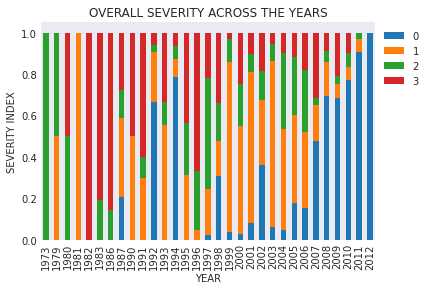

In [ ]:
# Plotting year and severity

severity_counts_by_year = pd.crosstab(clean_cb["YEAR"], clean_cb["SEVERITY_CODE"], normalize="index")
severity_counts_by_year.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1, 1))
plt.title("OVERALL SEVERITY ACROSS THE YEARS")
plt.ylabel("SEVERITY INDEX")
fig(1)

The graph above shows the ranking of $0$ (no bleaching) steadily increasing between 2004 and 2012 which could indicate areas that have previously experienced high bleaching have been fixed and are still being monitored.    

Intervention factors that have been introduced gradually throughout the years may have helped in reversing the damage caused to corals. Specifically, they may have targeted the reduction of greenhouse gas emissions that caused an increase in water temperature and resulted in bleaching, and thus coral mortality. Moreover, the potential increase in storm frequency and intensity could be another valid reason as to why coral bleaching has taken place due to increased gas emissions. Other potential problems are overfishing and destructive fishing with explosives. By reinforcing restrictions and creating marine protected areas (MPAs), the loss of corals and the ecosystems they support could have been restored. The reinforcement of MPAs would have also helped in disrupting the destruction inflicted upon the reefs through sewage leakage from land into the sea (Ritchie & Roser, 2021). 

Although there is an increasing proportion of $0$s in our dataset, this does not necessarily indicate an increase in the number of $0$s being recorded. This is because there may be less data recorded over time, and a larger proportion of the data happens to be $0$ (due to monitoring in areas of previous intervention). To confirm this, we have included a bar chart of the amount of $0$s recorded over time.

$\textbf{Figure 2}$

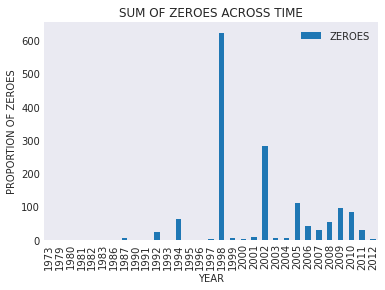

In [ ]:
severity_zeroes_by_year = {"YEAR": [], "ZEROES": []}
for i in sorted(clean_cb["YEAR"].unique()):
    severity_zeroes_by_year["YEAR"].append(i)
    severity_zeroes_by_year["ZEROES"].append(np.count_nonzero(clean_cb[clean_cb["YEAR"] == i]["SEVERITY_CODE"] == 0))
severity_zeroes_by_year_df = pd.DataFrame(severity_zeroes_by_year)
severity_zeroes_by_year_df.plot.bar(x="YEAR", y="ZEROES")
plt.title("SUM OF ZEROES ACROSS TIME")
plt.ylabel("PROPORTION OF ZEROES")
fig(2)

As there are very few $0$s in recent years (although the graph beforehand indicated a large proportion of the data was $0$), we can confirm that there is not an increase in $0$s being recorded and the high proportion of $0$s observed may indicate less data being recorded overall. If less data is recorded and the majority is $0$, this could indicate that data recorded in recent years has had intervention and is now being monitored; thus explaining the low severity.

To confirm this hypothesis, we plotted the amount of data recorded over time.

$\textbf{Figure 3}$

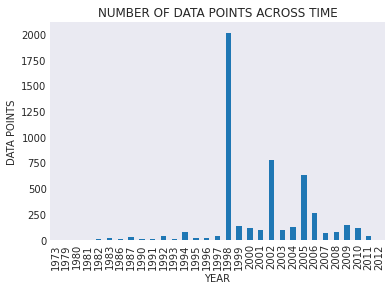

In [ ]:
# Get visualise data distribution across years
clean_cb["YEAR"].value_counts().sort_index().plot.bar(x=0, y=1)
plt.ylabel("DATA POINTS")
plt.xlabel("YEAR")
plt.title("NUMBER OF DATA POINTS ACROSS TIME")
fig(3)

The plot above confirms that less data has been recorded in recent years, and the shape of the data post 2005 is similar in both plots **SUM OF ZEROES ACROSS TIME** (Figure 2) and **NUMBER OF DATA POINTS ACROSS TIME** (Figure 3). As we have already established that a high proportion of the data in these years has a severity score of $0$, we can confirm our hypothesis.

The plot also shows that data prior to 1997 is scarce. We may speculate this could be due to a shortage of tools, means and interest in recording coral bleaching across the globe.

We then plotted average severity scores over time on a line chart to evaluate the trend of severity in monitored areas. However, as a regression line will be needed multiple times throughout the analysis, we first defined a generic function to plot one.

In [ ]:
# Plot regression line
def plot_regression_line(x, y, colour="red", log=False):
    m, c = np.polyfit(x, y, 1)
    plt.plot(x, m*x+c, color=colour)
    if log: print(f"Line of best fit: {m}x + {c}")

Line of best fit: -0.047827959140624765x + 96.94972103192245


$\textbf{Figure 4}$

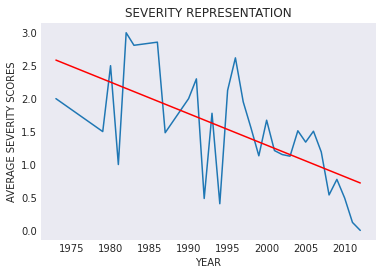

In [ ]:
# Plotting average severity by year
average_codes_by_year = {"YEAR": [], "SEVERITY_CODE": []}
for i in sorted(clean_cb["YEAR"].unique()):
    average_codes_by_year["YEAR"].append(i)
    average_codes_by_year["SEVERITY_CODE"].append(clean_cb[clean_cb["YEAR"] == i]["SEVERITY_CODE"].mean())
average_codes_by_year_df = pd.DataFrame(average_codes_by_year)
plt.plot(average_codes_by_year_df["YEAR"], average_codes_by_year_df["SEVERITY_CODE"])
plt.title("SEVERITY REPRESENTATION")
plt.xlabel("YEAR")
plt.ylabel("AVERAGE SEVERITY SCORES")
plot_regression_line(average_codes_by_year_df["YEAR"], average_codes_by_year_df["SEVERITY_CODE"], log=True)
fig(4)

The line of best fit shows a general downwards trend in average severity being recorded. The graph also showcases the sharp increase in severity following major bleaching events in 1998 and 2002. Notably, coral bleaching severity refers to the amount of coral mortality caused by external factors rather than the amount of coral bleaching caused on its own. Thus, we can see that alongside coral bleaching interventions, coral mortality could have majorly decreased (Great Barrier Reef Marine Park Authority, 2020).

To support our assessment of coral bleaching severity, we have employed another variable - percentage of coral affected. This variable refers to the proportion of reefs impacted by coral bleaching in a single area, which would help in assessing the severity in the area and applying intervention factors accordingly. To target bleaching, organisations need to identify more problematic areas to prioritise areas of high severity.

In [ ]:
# Add bleaching percentage
clean_cb_bleach_pct = add_from_cb(clean_cb, "PERCENTAGE_AFFECTED")
clean_cb_bleach_pct.head()

,REGION,SUBREGION,LAT,LON,YEAR,SEVERITY_CODE,PERCENTAGE_AFFECTED
29,Africa,Eastern Africa,-3.366667,40.483333,1998,3,50-90
31,Africa,Eastern Africa,-4.716667,39.366667,2010,3,66%
32,Africa,Eastern Africa,-1.986000,41.383000,2003,1,10-20%
39,Africa,Eastern Africa,-3.215000,40.127000,2003,1,10-20%
40,Africa,Eastern Africa,1.961400,41.300540,2010,3,72%


Unfortunately, the percentage affected variable had quite a few problems. The main issue was that the variable did not follow a strict data format and included strings in a note-like form. To rectify this, we employ the regular expressions below to extract the correct numeric values. In the case of a range, the average is calculated.

In [ ]:
# Cleaning percentage affected - extracting only percentage from column (and calculating average in case of range
# Ensures the column is numeric, which allows us to plot and perform operations on it
def clean_percentage_affected(val):
    # Check for ranges of values and take average
    m = re.search(r"([0-9]+)(\.[0-9]*)?%? *- *([0-9]+)(\.[0-9]*)?", val)
    if m:
        if m.group(2): i1 = float(m.group(1)+m.group(2))
        else: i1 = int(m.group(1))
        if m.group(4): i2 = float(m.group(3)+m.group(4))
        else: i2 = int(m.group(3))
        return float((i1+i2)/2)

    # Check for single value
    m2 = re.search(r"([0-9]+)(\.[0-9]*)?", val)
    if m2:
        return float(m2.group(0))

    # No value found
    return None

clean_cb_bleach_pct["PERCENTAGE_AFFECTED"] = clean_cb_bleach_pct["PERCENTAGE_AFFECTED"].apply(clean_percentage_affected)
clean_cb_bleach_pct = clean_cb_bleach_pct[~clean_cb_bleach_pct["PERCENTAGE_AFFECTED"].isnull()]
clean_cb_bleach_pct.head()

,REGION,SUBREGION,LAT,LON,YEAR,SEVERITY_CODE,PERCENTAGE_AFFECTED
29,Africa,Eastern Africa,-3.366667,40.483333,1998,3,70.0
31,Africa,Eastern Africa,-4.716667,39.366667,2010,3,66.0
32,Africa,Eastern Africa,-1.986000,41.383000,2003,1,15.0
39,Africa,Eastern Africa,-3.215000,40.127000,2003,1,15.0
40,Africa,Eastern Africa,1.961400,41.300540,2010,3,72.0


Due to the data being of a continuous categorical nature, we plotted the percentage affected variable against year to visualise the trend in the data. Thereby, trends that are plotted will help us answer questions regarding change over time. Another reason why we chose to do this is to see whether the dataset aligns with  information extracted from the literature.


Line of best fit: -1.5109417467282138x + 3052.3907784016787


$\textbf{Figure 5}$

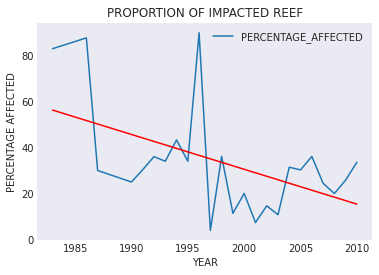

In [ ]:
# Plotting percentage affected against year
temp_df = clean_cb_bleach_pct.groupby("YEAR").mean().reset_index()
temp_df.plot(x="YEAR", y="PERCENTAGE_AFFECTED")
plt.xlabel("YEAR")
plt.ylabel("PERCENTAGE AFFECTED")
plt.title("PROPORTION OF IMPACTED REEF")
plot_regression_line(temp_df["YEAR"], temp_df["PERCENTAGE_AFFECTED"], log=True)
del temp_df
fig(5)

 
The plot shows a peak in coral bleaching around 1995 - as also found in our **SEVERITY REPRESENTATION** (Figure 4) plot - when major bleaching events had occurred as mentioned previously. 2006 also shows a peak which could be explained by what is referred to as the worst bleaching event in recent history, affecting $96\%$ of the GBR (Great Barrier Reef Foundation, 2021).


#### Water Temperature


Water temperature is an important factor to explore as coral is extremely sensitive to changes in water temperature. Rising water temperatures are a prominent cause of coral bleaching and even the slightest increase in temperature can disrupt their process of keeping algae that provide them with nutrients in their systems.


First, we made a new datatset including the `WATER_TEMPERATURE` variable.

In [ ]:
#Making a new dataframe including the water temperature
clean_cb_water_temp = add_from_cb(clean_cb, "WATER_TEMPERATURE")
clean_cb_water_temp.head()

,REGION,SUBREGION,LAT,LON,YEAR,SEVERITY_CODE,WATER_TEMPERATURE
34,Africa,Eastern Africa,-2.2456,41.0642,1998,1,32.5
42,Africa,Eastern Africa,-3.9850,39.7620,2003,1,31.2 and 33.4C (Peak at shallow area)
76,Africa,Eastern Africa,-27.5260,32.6880,2000,1,25–27 8C (summer)
77,Africa,Eastern Africa,-27.5260,32.6880,2001,1,21-23C (winter)
78,Africa,Eastern Africa,-27.5260,32.6880,2001,1,25–27 8C (Summer)


Unfortunately this variable was also quite problematic as, like percentage affected, the data was not consistently formatted and required regular expressions to extract.

In [ ]:
# Clean water temperature field
def clean_water_temp(val):
    explicit_water_temp = re.search("water temp ([0-9][0-9])", val, flags=re.IGNORECASE)
    if explicit_water_temp:
        return int(explicit_water_temp.group(1))
    implicit_water_temp = re.search("([0-9][0-9])", val, flags=re.IGNORECASE)
    if implicit_water_temp:
        return int(implicit_water_temp.group(0))
    return None


clean_cb_water_temp["WATER_TEMPERATURE"] = clean_cb_water_temp["WATER_TEMPERATURE"].apply(clean_water_temp)
# Assume any temperature over 60 is in fahrenheit as this value in celsius would be higher than ever recorded in history
clean_cb_water_temp["WATER_TEMPERATURE"] = clean_cb_water_temp["WATER_TEMPERATURE"].apply(lambda x: (x-32)*5/9 if x > 60 else x)
clean_cb_water_temp = clean_cb_water_temp[~clean_cb_water_temp["WATER_TEMPERATURE"].isnull()]
clean_cb_water_temp.head()

,REGION,SUBREGION,LAT,LON,YEAR,SEVERITY_CODE,WATER_TEMPERATURE
34,Africa,Eastern Africa,-2.2456,41.0642,1998,1,32.0
42,Africa,Eastern Africa,-3.9850,39.7620,2003,1,31.0
76,Africa,Eastern Africa,-27.5260,32.6880,2000,1,25.0
77,Africa,Eastern Africa,-27.5260,32.6880,2001,1,21.0
78,Africa,Eastern Africa,-27.5260,32.6880,2001,1,25.0


 

Here we have plotted water temperature by year to gauge the change in water temperatures over time, which would in turn affect coral bleaching.


$\textbf{Figure 6}$

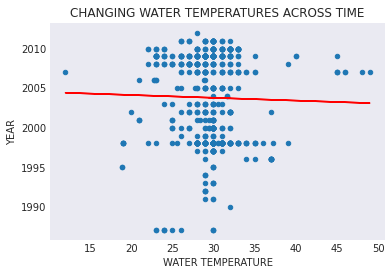

In [ ]:
# Plot water temperature
clean_cb_water_temp.plot.scatter(y="YEAR", x="WATER_TEMPERATURE")
plot_regression_line(clean_cb_water_temp["WATER_TEMPERATURE"], clean_cb_water_temp["YEAR"])
plt.xlabel("WATER TEMPERATURE")
plt.title("CHANGING WATER TEMPERATURES ACROSS TIME")
fig(6)

Although the data was continuous and we had cleared the dataset of notelike descriptions in this category, the units used to measure water temperature were not consistent. Data was recorded in both Celsius (C) and Fahrenheit (F). We plotted the graph assuming all the temperatures were in Celsius apart from those above 60, which we then recoded into Celsius from Fahrenheit. However, this means that many points recorded in Fahrenheit will still be presented as Celsius and we cannot effectively isolate all cases. Furthermore, as we took the first two numerical digits (except in cases of a range), the note like form the data was recorded in means that the extracted data is not necessarily the water temperature. For example, air temperature was frequently recorded first and sometimes the data was written in note form such as “approximately 5 deg. colder than yesterday” which is not appropriate for analysis.

### Severity across Regions
As `REGION` is a discrete variable we have plotted a bar chart showing the proportional severity of monitored areas to each region to evaluate how the severity differs across location. According to Shuail et al. (2016) the world’s most tolerant corals are in southern Persian/Arabian Gulf, which can tolerate temperatures up to $\sim35\degree\text{C}$. Therefore, we expect our data to show lower bleaching in the Middle East and higher bleaching in Australia to account for the bleaching in the GBR.


We plotted the data as a percentage of total data collected in each region to account for some regions being more closely monitored than others, and therefore having more data.

$\textbf{Figure 7}$

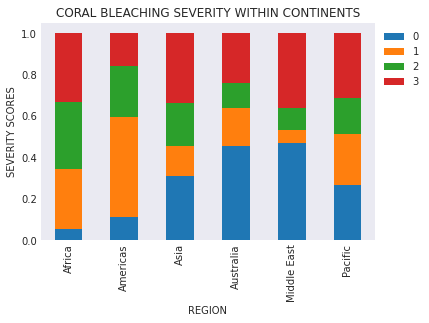

In [ ]:
# Bar chart of region vs severity
region_vs_severity_crosstab = pd.crosstab(clean_cb["REGION"], clean_cb["SEVERITY_CODE"], normalize="index")
region_vs_severity_crosstab.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1, 1))
plt.title("CORAL BLEACHING SEVERITY WITHIN CONTINENTS")
plt.ylabel("SEVERITY SCORES")
fig(7)

This shows that in our dataset Africa has the largest amount of $3$s proportional to the data collected and the smallest amount of $0$s indicating higher severity, whereas Australia has a large number of $0$s proportional to the data collected and a smaller proportion of $3$s indicating less bleaching. This is different than hypothesised but could be due to a large quantity of data as Australia is a focus point for coral bleaching due to the GBR, however only a small portion of the data from Australia may indicate bleaching if most of the data is neutral. The Middle East shows fewer $1$ or $2$ ranks proportional to the data collected indicating most of the data recorded was at the extreme ends of the scale, thus most coral bleaching recorded there was either severe or none was found. The Americas and Pacific show consistent milder amounts of bleaching. 

As the literature had suggested and according to the data represented above, it is evident that the Middle East shows the least amount of severity for coral bleaching. This is potentially due to the corals having a higher tolerance and adaptation to higher temperatures ($\sim35\degree\text{C}$), whereas Eastern and Southern African Reefs are only able to survive in $28\degree\text{C}$ water temperatures. Thus, we can see that they have a lower tolerance to rising water temperatures. Both Asia and the Middle East show similar severity code ratios, which could indicate a similar diversity of corals in those regions; although some corals have adapted to rising temperatures, some have not and are continuously affected by this factor.

To explore our hypothesis that Australia's seemingly low bleaching severity is a result of abundant monitoring, we need to look at how much data has been recorded for each region.

$\textbf{Figure 8}$

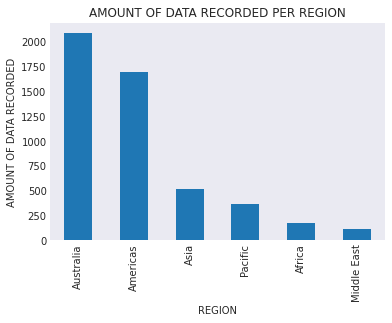

In [ ]:
clean_cb["REGION"].value_counts().plot.bar()
plt.title("AMOUNT OF DATA RECORDED PER REGION")
plt.ylabel("AMOUNT OF DATA RECORDED")
plt.xlabel("REGION")
fig(8)

As we can see above, Australia has the most data which could be indicative of a large amount of monitoring of coral bleaching due to the bleaching events with the GBR, further supporting our hypothesis.

#### Bleaching at Different Distances from Equator
To see what effect location has on the severity of coral beaching we need to make a continuous "distance from equator" variable. We created this variable by making an absolute value for the distance from the equator using the Latitude value (`LAT`), and plotted this against percentage affected and severity code. Previous research has shown that not all coral reefs are exposed to the same severity of temperature stressors, with corals also displaying local and regional variation in their responses to thermal stress (Sully, 2019). Therefore, analysing the distance from the equator variable provides an indication of locations experiencing the highest severity of bleaching. 


In [ ]:
# Distance from equator calculation
clean_cb["EQUATOR_DISTANCE"] = np.abs(clean_cb["LAT"])
# Bin equator distance
clean_cb["EQUATOR_DISTANCE_BINNED"] = pd.cut(
    x=clean_cb["EQUATOR_DISTANCE"],
    bins=[0, 5, 10, 15, 25, 30, 35, 50],
    labels=["0-5", "5-10", "10-15", "15-20", "20-25", "30-35", "35+"]
)
clean_cb.head()

,REGION,SUBREGION,LAT,LON,YEAR,SEVERITY_CODE,EQUATOR_DISTANCE,EQUATOR_DISTANCE_BINNED
29,Africa,Eastern Africa,-3.366667,40.483333,1998,3,3.366667,0-5
30,Africa,Eastern Africa,-4.073000,39.690000,2005,1,4.073000,0-5
31,Africa,Eastern Africa,-4.716667,39.366667,2010,3,4.716667,0-5
32,Africa,Eastern Africa,-1.986000,41.383000,2003,1,1.986000,0-5
33,Africa,Eastern Africa,-1.750000,41.483300,2001,3,1.750000,0-5


We then plotted the distance on a histogram to show the data distribution geographically. In order to make a continuous variable of distance from the equator, we used the absolute latitude value to remove negatives.

$\textbf{Figure 9}$

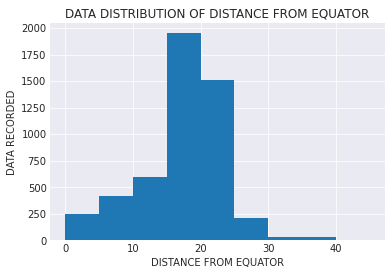

In [ ]:
# Plot equator distance bins on histogram
clean_cb.hist(column="EQUATOR_DISTANCE", bins=[0, 5, 10, 15, 20, 25, 30, 40, 45])
plt.title("DATA DISTRIBUTION OF DISTANCE FROM EQUATOR")
plt.xlabel("DISTANCE FROM EQUATOR")
plt.ylabel("DATA RECORDED")
fig(9)

The plot above shows data was collected over a wide range of distances, however the distribution of data collection was not equal. There is an increase leading up to a sudden peak around $\pm15$ latitude from the equator before the data quickly tapers off.  

$15^\text{th}$ parallel north is the imaginary line $15$ degrees north of the Earth’s equator (as pictured on the image below), and it crosses the following locations: the Saharan fringe in Africa, three key peninsulas of Asia (between which parts of the Indian Ocean), the Pacific Ocean, an isthmus of Central America, the Southern Caribbean and the Atlantic Ocean.

$15^\text{th}$ parallel south is the line $15$ degrees south of the Earth’s equator and it crosses the following locations: the Atlantic Ocean, Africa, the Indian Ocean, Australasia, the Pacific Ocean and South America.

The areas mentioned above have been selected and are a part of the ReefBase dataset used in this project, containing information from the National Oceanographic and Atmospheric Administration (NOAA), Australian Institute of Marine Science (AIMS) and Great Barrier Reef Marine Park Authority (GBRMPA) (Gowey, 2010). Due to the data concentration being mostly in this area, this has been shown in the graph above.

![alt text](images/coral_bleaching_latitude.jpeg)

The next part of our analysis looks at the severity code against distance from the equator. Locations closer to the equator typically have higher water temperatures, therefore we can theorise they will have higher bleaching severity. The following analysis allows us to test this hypothesis. 

We chose the "geopandas" library to represent our data and added a slider to scroll through the years to see how severity and distribution change over time. Unfortunately, due to the slider function not working in deepnote, we instead selected a single year at a time and changed the year manually for comparison. The slider could theoretically work on a local machine which has geopandas and ipywidgets installed. We originally selected the year with the most data points as it may be the most interesting to visualise.

Referring to the plot **NUMBER OF DATA POINTS ACROSS TIME** (Figure 3) in the [Severity Scores across Time](#severity-scores-over-time) section, we can determine that the year 1998 had the highest volume of data. Thus, we used this year to inspect severity distribution. We first needed to confirm this year had a somewhat typical data distribution, as the data volume was itself atypical.

$\textbf{Figure 10}$

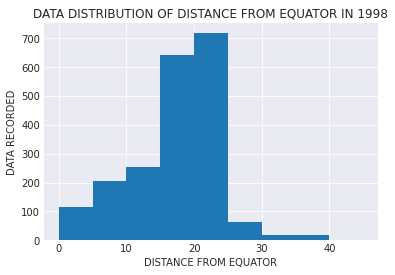

In [ ]:
# Plot equator distance bins on histogram
clean_cb[clean_cb["YEAR"] == 1998].hist(column="EQUATOR_DISTANCE", bins=[0, 5, 10, 15, 20, 25, 30, 40, 45])
plt.title("DATA DISTRIBUTION OF DISTANCE FROM EQUATOR IN 1998")
plt.xlabel("DISTANCE FROM EQUATOR")
plt.ylabel("DATA RECORDED")
fig(10)

Comparing the distribution of data in 1998 and the total distribution, we can see the same gradual then sudden increase in frequency density at approximately $\pm15$ latitude from the equator before the amount of data collected suddenly drops to around $0$. Therefore, we can say the data collection was typical of the overall dataset other than the volume of data recorded. This does raise a potential concern of whether the volume of data collected in 1998 is what caused the total data distribution. To address this, we plotted the data distribution from all years except 1998.

$\textbf{Figure 11}$

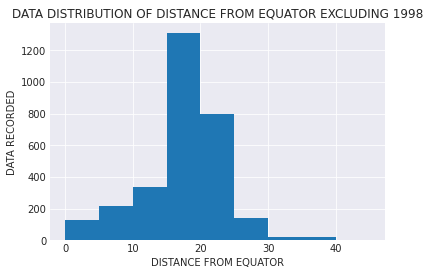

In [ ]:
# Plot equator distance bins on histogram and remove data from 1998
clean_cb[clean_cb["YEAR"] != 1998].hist(column="EQUATOR_DISTANCE", bins=[0, 5, 10, 15, 20, 25, 30, 40, 45])
plt.title("DATA DISTRIBUTION OF DISTANCE FROM EQUATOR EXCLUDING 1998")
plt.xlabel("DISTANCE FROM EQUATOR")
plt.ylabel("DATA RECORDED")
fig(11)

As the shape of the graph still looks fairly similar, we can use 1998 as a stereotyped year to present data from in the demonstration.

As sliders do not work on Deepnote, work on the slider was abandoned and it does not function. Instead, please alter the `YEAR` variable in the block below, then rerun the block to view severity codes for different years.

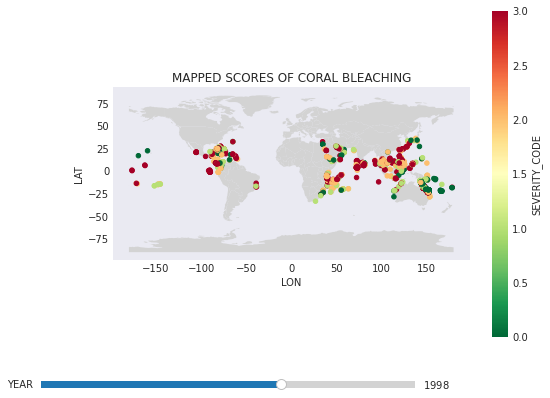

$\textbf{Figure 12}$

In [ ]:
# Alter this variable
# min = 1973, max = 2012

YEAR = 1998


############
_, ax = plt.subplots(figsize=(8,6))
plt.title("MAPPED SCORES OF CORAL BLEACHING")
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)

clean_cb[clean_cb["YEAR"] == YEAR].plot(
    x="LON", y="LAT", kind="scatter", 
    c="SEVERITY_CODE", colormap="RdYlGn_r", 
    title=f"", 
    ax=ax
)

axyear = plt.axes([0, 0, 0.65, 0.03])
year = matplotlib.widgets.Slider(
    ax=axyear, label="YEAR",
    valmin=np.min(clean_cb["YEAR"]),
    valmax=np.max(clean_cb["YEAR"]),
    valinit=YEAR
)

def update(val):
    clean_cb[clean_cb["YEAR"] == val].plot(
        x="LON", y="LAT", kind="scatter",
        c="SEVERITY_CODE", colormap="RdYlGn_r",
        title=f"",
        ax=ax
    )
year.on_changed(update)


plt.show()
fig(12)

The geopandas plot created a visual representation of severity codes across the years at different locations from the equator, with higher severity marked in red and lower severity marked in green. The map for the year 1998 shows that locations closer to the equator experience higher severity of bleaching as predicted, and lower severity points are distributed on the plot further away from the equator line. This map shows the geographical distribution of severity, with the highest severity of bleaching occurring at mid-latitude locations ($15\text{--}20$ degrees north and south of the equator) - a consistent trend over time. This may be attributed to the aforementioned warmer temperatures causing increased severity at these locations alongside damaging fishing practices being conducted within these regions. Within the period we’re studying, the GBR suffered several major bleaching events. In the animation it is evident that the GBR was heavily monitored in 1998 and 2002 (Berkelmans et al., 2004), and we can speculate that this is as a result of the bleaching.

![animation](images/animation.gif)

### Intervention index



We created an intervention index for each location based on how many times that place has been recorded. We did this by rounding values from `LON` and `LAT` to the nearest integers and treating each coordinate as a location, then assumed that multiple recordings would indicate a higher level of monitoring and therefore more intervention.

Creating an intervention index is important as if we can isolate and remove the effect of intervention from bleaching severity, we can predict how much bleaching is minimised by intervention and what effect environmental factors would be having on bleaching if left unmoderated. 

In [ ]:
# Create a new dataframe with the necessary fields and formulate a 'location' for each row by rounding
# their longitudes and latitudes to the nearest whole number.
# By grouping data taken in close proximity together, we can then design a measure of intervention for
# those locations.
clean_cb_intervention = add_from_cb(pd.DataFrame(), ["REGION", "SUBREGION", "LAT", "LON", "YEAR", "SEVERITY_CODE", "PERCENTAGE_AFFECTED"])
clean_cb_intervention["PERCENTAGE_AFFECTED"] = clean_cb_intervention["PERCENTAGE_AFFECTED"].apply(clean_percentage_affected)
clean_cb_intervention["LOCX"] = np.rint(clean_cb_intervention["LON"])
clean_cb_intervention["LOCY"] = np.rint(clean_cb_intervention["LAT"])
clean_cb_intervention["LOC"] = [str(int(row["LOCX"])) + "," + str(int(row["LOCY"])) for ind, row in clean_cb_intervention.iterrows()]
clean_cb_intervention.head()

,REGION,SUBREGION,LAT,LON,YEAR,SEVERITY_CODE,PERCENTAGE_AFFECTED,LOCX,LOCY,LOC
29,Africa,Eastern Africa,-3.366667,40.483333,1998,3,70.0,40.0,-3.0,"40,-3"
31,Africa,Eastern Africa,-4.716667,39.366667,2010,3,66.0,39.0,-5.0,"39,-5"
32,Africa,Eastern Africa,-1.986000,41.383000,2003,1,15.0,41.0,-2.0,"41,-2"
39,Africa,Eastern Africa,-3.215000,40.127000,2003,1,15.0,40.0,-3.0,"40,-3"
40,Africa,Eastern Africa,1.961400,41.300540,2010,3,72.0,41.0,2.0,"41,2"


We calculated an intervention index based on how many times a location has been measured. We predicted that the number of times a location has been measured may indicate the level of intervention at this location. 

In [ ]:
# Calculate intervention index
# index will be the number of times the location has been measured in the same and previous years
intervention_indexes = {}
intervention_indexes_final = {}
for _, row in clean_cb_intervention.sort_values(by="YEAR").iterrows():
    l, y = row["LOC"], row["YEAR"]
    # ensure location in dict
    if l not in intervention_indexes:
        intervention_indexes[l] = {}
        intervention_indexes_final[l] = 0
    # ensure year in location
    if y not in intervention_indexes[l]:
        intervention_indexes[l][y] = intervention_indexes_final[l]
    # increment values
    intervention_indexes[l][y] += 1
    intervention_indexes_final[l] += 1
# add new column
clean_cb_intervention["INTERVENTION"] = [
    intervention_indexes[row["LOC"]][row["YEAR"]] for _, row in clean_cb_intervention.iterrows()
]
# Create a dataframe of all intervention indexes
intervention_indexes_df = pd.DataFrame(intervention_indexes).sort_index()

clean_cb_intervention.head()

,REGION,SUBREGION,LAT,LON,YEAR,SEVERITY_CODE,PERCENTAGE_AFFECTED,LOCX,LOCY,LOC,INTERVENTION
29,Africa,Eastern Africa,-3.366667,40.483333,1998,3,70.0,40.0,-3.0,"40,-3",1
31,Africa,Eastern Africa,-4.716667,39.366667,2010,3,66.0,39.0,-5.0,"39,-5",3
32,Africa,Eastern Africa,-1.986000,41.383000,2003,1,15.0,41.0,-2.0,"41,-2",1
39,Africa,Eastern Africa,-3.215000,40.127000,2003,1,15.0,40.0,-3.0,"40,-3",2
40,Africa,Eastern Africa,1.961400,41.300540,2010,3,72.0,41.0,2.0,"41,2",2


Below we plotted the 50 most recorded locations to visualise the distribution of interventions.

$\textbf{Figure 13}$

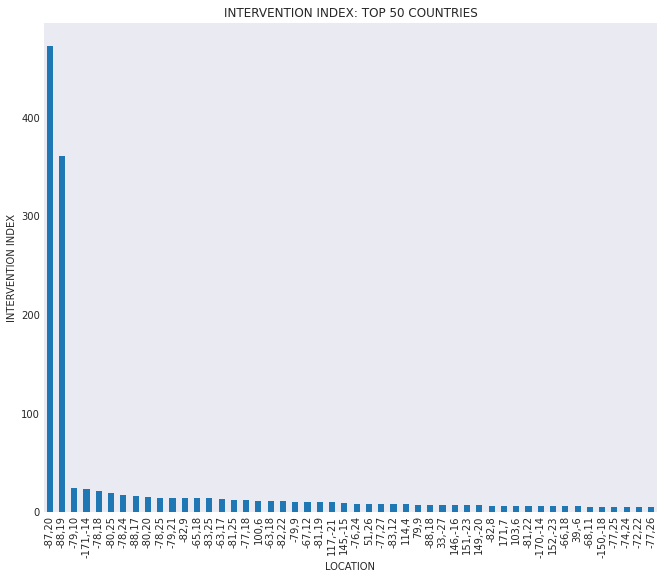

In [ ]:
# Plot top 50 locations in terms of intervention index
_, ax = plt.subplots(1, 1, figsize=(11,9))
pd.Series(intervention_indexes_final).nlargest(50).plot.bar(ax=ax)
plt.xlabel("LOCATION")
plt.ylabel("INTERVENTION INDEX")
plt.title("INTERVENTION INDEX: TOP 50 COUNTRIES")
fig(13)

 
The graph above shows the distribution of intervention. From this we can see that locations at  $(-87,20)$ and $(-88,19)$ have the highest intervention indexes; the former being recorded over 400 times. In comparison, location $(-77,26)$ has only been measured approximately 10 times. The higher intervention index may be related to areas experiencing higher severity, as more focus may be placed on these areas. However, it is also possible that these areas were more accessible and had a higher abundance of resources.


An issue we then have is that not every location is represented every year. While this would normally be fine, when calculating yearly averages it is important that the same locations are averaged every year to enable comparison. To rectify this, we formulated an algorithm to do two things:

1. Estimate values of percentage affected for each location in each year where they are not already present
    1. Search backwards in time for the most recent value for that location
    2. Search forwards in time for the next value for that location
    3. Use these values to estimate the missing value with the following equation:
        $v_y=v_p+\frac{v_n-v_p}{x_n-x_p}\times(x_y-x_p)$  
        where $x_p$ is the last year data was recorded for the location, $x_n$ is the next year data is recorded  and $x_y$ is the year we are estimating data for,  
        $v_p$ is the vaue recorded in $x_p$ and $v_n$ is the value recorded in $x_n$,  
        $v_y$ is the estimated value
        - this equation takes the average of the two points while considering the distance between each of them as it is unlikely the estimated value is halfway between them
        - the estimated value assumes linearity
    4. If only one of the previous value or next value exists, use that one
    5. If no previous or next values are found (should be impossible), a value of $0$ is assigned
2. Add the most recent intervention index where it is not already present
    - we do not need to estimate anything here as the intervention index is a measure of how many times data has been collected from a location

In [ ]:
# Average percentage affected and intervention index
complete_avg_pct_affected_int_index_per_year_df = pd.DataFrame()
# Sort so largest pct affected values for each year are last
clean_cb_intervention.sort_values(by=["LOC", "PERCENTAGE_AFFECTED"], ascending=True, inplace=True)
# Remove all duplicates (keep last, which will be largest for that location in that year)
temp = clean_cb_intervention.drop_duplicates(subset=["YEAR", "LOC"], keep="last")
# Create dictionary for percentage affected with key year and subkey location - this dictionary will have an entry for every location in every year
all_locations = temp["LOC"].unique()
all_years = temp["YEAR"].unique()
pct_aff_by_loc_by_year_dict = {}
int_ind_by_loc_by_year_dict = {}
# init empty dict for all years
for y in all_years:
    pct_aff_by_loc_by_year_dict[y] = {}
    int_ind_by_loc_by_year_dict[y] = {}
# populate dict
for y in all_years:
    for l in all_locations:
        rows = temp[(temp["YEAR"] == y) & (temp["LOC"] == l)]
        if rows["PERCENTAGE_AFFECTED"].size > 0:
            pct_aff_by_loc_by_year_dict[y][l] = rows["PERCENTAGE_AFFECTED"].iloc[-1] # last, and thus largest
            int_ind_by_loc_by_year_dict[y][l] = rows["INTERVENTION"].iloc[-1]
        else:
            # iterate through previous years till the last known value is found
            prev_val = None
            check_year_p = y
            rows = pd.Series(dtype="float64")
            while rows.size == 0:
                check_year_p -= 1
                if check_year_p < np.min(all_years):
                    break # break if prev_year is obviously out of bounds
                rows = temp[(temp["YEAR"] == check_year_p) & (temp["LOC"] == l)]["PERCENTAGE_AFFECTED"]
            if rows.size != 0:
                prev_val = rows.iloc[-1]
            # iterate through next years till the next value is found
            next_val = None
            check_year_n = y
            rows = pd.Series(dtype="float64")
            while rows.size == 0:
                check_year_n += 1
                if check_year_n > np.max(all_years):
                    break # break if next_year is obviously out of bounds
                rows = temp[(temp["YEAR"] == check_year_n) & (temp["LOC"] == l)]["PERCENTAGE_AFFECTED"]
            if rows.size != 0:
                next_val = rows.iloc[-1]
            if prev_val != None and next_val != None:
                # estimate what pct aff should be for the year we're checking
                pct_aff_by_loc_by_year_dict[y][l] = prev_val + ((next_val - prev_val) / (check_year_n - check_year_p)) * (y - check_year_p)
                # set int ind to prev
                int_ind_by_loc_by_year_dict[y][l] = temp[(temp["YEAR"] == check_year_p) & (temp["LOC"] == l)]["INTERVENTION"].iloc[-1]
            elif prev_val != None:
                pct_aff_by_loc_by_year_dict[y][l] = prev_val
                int_ind_by_loc_by_year_dict[y][l] = temp[(temp["YEAR"] == check_year_p) & (temp["LOC"] == l)]["INTERVENTION"].iloc[-1]
            elif next_val != None:
                pct_aff_by_loc_by_year_dict[y][l] = next_val
                int_ind_by_loc_by_year_dict[y][l] = 0
            else:
                pct_aff_by_loc_by_year_dict[y][l] = 0
                int_ind_by_loc_by_year_dict[y][l] = 0

pct_aff_by_loc_by_year_df = pd.DataFrame(pct_aff_by_loc_by_year_dict).transpose()
int_ind_by_loc_by_year_df = pd.DataFrame(int_ind_by_loc_by_year_dict).transpose()
    

Now we have individual data frames with complete data for every location in every year, we should combine them to achieve a single data frame with both intervention index and percentage affected for use in the future.

In [ ]:
# Collate both of these into a single dataframe
temp = {"YEAR": [], "LOC": [], "PERCENTAGE_AFFECTED": [], "INTERVENTION": []}
# add data to temporary dictionary
for ind, row in pct_aff_by_loc_by_year_df.iterrows():
    for l in all_locations:
        temp["YEAR"].append(ind)
        temp["LOC"].append(l)
        temp["PERCENTAGE_AFFECTED"].append(row[l])
        temp["INTERVENTION"].append(int_ind_by_loc_by_year_df.loc[ind][l])

# use temporary dictionary to create dataframe and delete temporary dictionary
complete_avg_pct_affected_int_index_per_year_df = pd.DataFrame(temp)
del temp
# create copy dataframe for future use
map_int_df = complete_avg_pct_affected_int_index_per_year_df.copy()
complete_avg_pct_affected_int_index_per_year_df.head()

,YEAR,LOC,PERCENTAGE_AFFECTED,INTERVENTION
0,2000,"-109,-27",87.500000,1
1,2000,"-149,-17",20.000000,0
2,2000,"-149,-18",25.500000,1
3,2000,"-150,-17",29.050000,0
4,2000,"-150,-18",25.672727,4


At this point, we can plot intervention visually on a map. Again, the `YEAR` variable must be manually set as Deepnote does not support ipywidgets sliders.

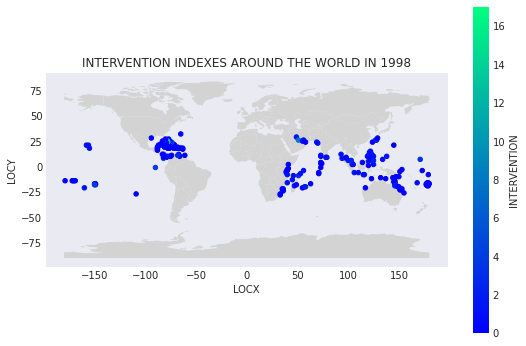

$\textbf{Figure 14}$

In [ ]:

# Alter this variable
# min = 1973, max = 2012

YEAR = 1998


############
_, ax = plt.subplots(figsize=(9,6))

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)

map_int_df["LOCX"] = [int(i.split(",")[0]) for i in map_int_df["LOC"]]
map_int_df["LOCY"] = [int(i.split(",")[1]) for i in map_int_df["LOC"]]
map_int_df[map_int_df["YEAR"] == YEAR].plot(
    x="LOCX", y="LOCY", kind="scatter", 
    c="INTERVENTION", colormap="winter", 
    title=f"", 
    ax=ax
)

plt.title(f"INTERVENTION INDEXES AROUND THE WORLD IN {YEAR}")

plt.show()
fig(14)

The plot above shows the distribution of intervention indexes for different locations. The map shows a large distribution of intervention points, the spread of which may be explained by the availability of resources such as local research teams and widespread low scale intervention methods aimed at addressing coral bleaching. Interventions such as implementing fishing restrictions and creating protected areas of reef are being implemented globally by organisations such as the Coral Reef Alliance and thus this could explain the widespread distribution of repeated measurements being observed as they may be regularly monitored. This is supported by the fact areas shown to have a higher intervention index appear to be located at significant reef sites, such as the Andros Barrier Reef in the Bahamas which is one of the largest coral reefs in the world and  is shown to have a high amount of repeated data collection.

In addition to this we can see varying scales of interventions at a specific location over the years. The Great Barrier Reef demonstrates an increase in intervention around the year 2002 from previous years such as 1985. Around this time there were significant climate change events referred to as the El Niño events that caused an increase in water temperatures. The events were significant not just in their damaging effects but also in their media coverage which in turn led to increased awareness of coral bleaching. Ergo, the El Niño events may explain the increase in interventions around this time and the increase in monitoring that was conducted.

Next, we computed the averages for each year to reduce the number of data points plotted and visualise correlations more clearly.

In [ ]:
# Get averages for each year
complete_avg_pct_affected_int_index_per_year_non_mean_df = complete_avg_pct_affected_int_index_per_year_df.copy()
complete_avg_pct_affected_int_index_per_year_df = complete_avg_pct_affected_int_index_per_year_df.groupby("YEAR").mean()
complete_avg_pct_affected_int_index_per_year_df.head()

,PERCENTAGE_AFFECTED,INTERVENTION
YEAR,,
1983,38.943862,0.073394
1985,38.678364,0.077982
1986,38.545615,0.082569
1987,38.417645,0.151376
1990,38.326120,0.160550


Using the average percentage affected and year, we plotted the averages to obtain a correlation which we could then compare to a similar graph using the intervention index.

Below we define some simple functions to easily calculate correlation coefficients for analysis.

In [ ]:
def standard_units(x):
    return (x - np.mean(x)) / np.std(x)
def correlation(x, y, log=False):
    r = np.mean(standard_units(x) * standard_units(y))
    if log: print(f"Correlation: {r}")
    return r

Now we have a complete representation of all locations in all years comprising our averages, we can plot these averages again for some more useful insights.

Line of best fit: -0.046398368337541726x + 130.5133496422465
Correlation: -0.4676534006506818


$\textbf{Figure 15}$

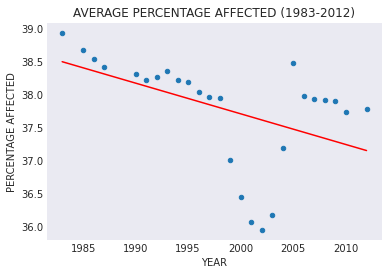

In [ ]:
# Plot average percentage affected by year
complete_avg_pct_affected_int_index_per_year_df.reset_index().plot.scatter(x="YEAR", y="PERCENTAGE_AFFECTED")
plot_regression_line(complete_avg_pct_affected_int_index_per_year_df.reset_index()["YEAR"], complete_avg_pct_affected_int_index_per_year_df.reset_index()["PERCENTAGE_AFFECTED"], log=True)
correlation(complete_avg_pct_affected_int_index_per_year_df.reset_index()["YEAR"], complete_avg_pct_affected_int_index_per_year_df.reset_index()["PERCENTAGE_AFFECTED"], log=True)
plt.ylabel("PERCENTAGE AFFECTED")
plt.title("AVERAGE PERCENTAGE AFFECTED (1983-2012)")
fig(15)

Plotted above is the percentage of coral affected by bleaching against year. We can see a negative trend in the data showing an overall decrease in percentage affected over time, with an intriguing dip in the latter half between the years 2000 to 2005.

To investigate the potential reason for this dip, we plotted the amount of percentage affected data we had against year to see if it could provide any insight into the difference.

$\textbf{Figure 16}$

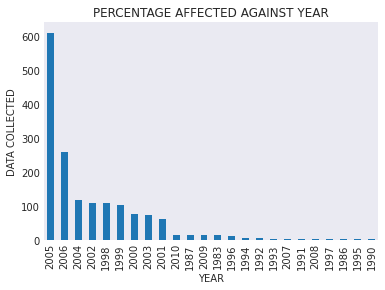

In [ ]:
# Plot amount of percentage affected data recorded for each year
clean_cb_bleach_pct["YEAR"].value_counts().plot.bar()
plt.title("PERCENTAGE AFFECTED AGAINST YEAR")
plt.ylabel("DATA COLLECTED")
plt.xlabel("YEAR")
fig(16)

From the plot above, we can ascertain that the percentage affected variable was used a lot more frequently between 1998 and 2006 - this could be explained by a combination of the El Niño events and the 2002 GBR bleaching resulting in increased concern and monitoring. Looking back at our **SEVERITY REPRESENTATION** (Figure 4) plot under the [Severity scores over Time](#severity-scores-over-time) section, there is a dip in severity codes around this period. While the dip is not as significant as previous fluctuations, the reason it's so heavily represented on the **AVERAGE PERCENTAGE AFFECTED** (Figure 15) plot could be due to the fact `PERCENTAGE_AFFECTED` data was being recorded more overall, whereas outside this range it may have only been collected when monitoring severe levels of bleaching.

Below we plotted the intervention index by year to visualise the trend in the increase of the intervention index.

Line of best fit: 0.3154267018773105x + -627.7491585204226
Correlation: 0.8745450165788976


$\textbf{Figure 17}$

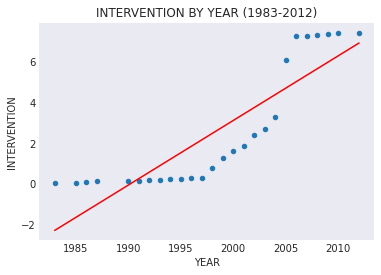

In [ ]:
# Plot average intervention by year
complete_avg_pct_affected_int_index_per_year_df.reset_index().plot.scatter(x="YEAR", y="INTERVENTION")
plot_regression_line(complete_avg_pct_affected_int_index_per_year_df.reset_index()["YEAR"], complete_avg_pct_affected_int_index_per_year_df.reset_index()["INTERVENTION"], log=True)
correlation(complete_avg_pct_affected_int_index_per_year_df.reset_index()["YEAR"], complete_avg_pct_affected_int_index_per_year_df.reset_index()["INTERVENTION"], log=True)
plt.title("INTERVENTION BY YEAR (1983-2012)")
fig(17)

Above we see the cumulative yearly intervention. Overall the trend seems fairly linear - somewhat expected of a cumulative plot - however the rate of intervention does somewhat increase around the year 2000 when compared to 1985 and 1998 which was fairly slow. The sudden rapid increase in intervention from 2000 to 2010 may be a result of the El Niño events, resulting in a worsening of coral living conditions and ergo stressing the coral. Due to raised awareness of threats to coral survival as a result of El Niño (as previously discussed), more interventions may have been introduced.

By plotting the derivative of the intervention index by year ($\frac{dy}{dx}$) we can evaluate the rate of change by which intervention increased.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


$\textbf{Figure 18}$

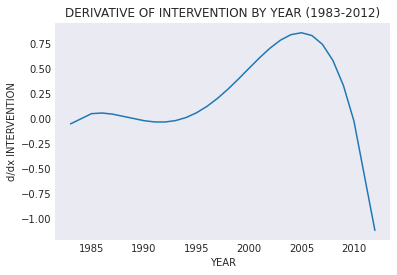

In [ ]:
# Plot derivative of above scatter
# deg defines how granular to make the fit of the curve
deg = 10
fit = np.polyfit(complete_avg_pct_affected_int_index_per_year_df.reset_index()["YEAR"], complete_avg_pct_affected_int_index_per_year_df.reset_index()["INTERVENTION"], deg)
# calculate derivative of polynomial
dydx = np.polyder(np.poly1d(fit))
# plot derivative
plt.title("DERIVATIVE OF INTERVENTION BY YEAR (1983-2012)")
plt.ylabel("d/dx INTERVENTION")
plt.xlabel("YEAR")
plt.plot(complete_avg_pct_affected_int_index_per_year_df.reset_index()["YEAR"], dydx(complete_avg_pct_affected_int_index_per_year_df.reset_index()["YEAR"]))
fig(18)

We can confirm that as previously hypothesised, between 1995 and 2006 the rate of change did dramatically increase before tapering off. The latter reduction could be due to the many environmental catastrophes that had occurred following the year 2007. One of the most devastating ones was the Deepwater Horizon oil spill in 2010 and a similar but less severe incident in 2008 (Pallardy, 2019). Knowing that oil can impede coral growth and development, it could be speculated this is why intervention factors were not as effective thereafter and the dataframe does not continue long enough to observe potential recovery.

We then defined some helper functions to assist in calculating residuals.

In [ ]:
def ss_any_line(c_s, x_values, y_values):
    c, s = c_s
    predicted = c + x_values * s
    error = y_values - predicted
    return np.sum(error ** 2)
def calc_residuals(input_df, x_col_name, y_col_name):
    c, m = minimize(ss_any_line, [0, 0], args=(input_df[x_col_name], input_df[y_col_name])).x
    residuals = []
    for i in range(input_df.shape[0]):
        x = input_df[x_col_name].iloc[i]
        y = input_df[y_col_name].iloc[i]
        residuals.append(y - (c + x * m))
    return np.array(residuals)

Next, we removed the effect of intervention from percentage affected to see if this gives us a clearer view.

In [ ]:
# Calculate residuals for predicting percentage affected from intervention
year_from_intervention_residuals = calc_residuals(complete_avg_pct_affected_int_index_per_year_df.reset_index(), "INTERVENTION", "YEAR")
pct_from_intervention_residuals = calc_residuals(complete_avg_pct_affected_int_index_per_year_df.reset_index(), "INTERVENTION", "PERCENTAGE_AFFECTED")

Line of best fit: -0.034639146129200146x + 69.21567534968399
Correlation: -0.3523822017284026


$\textbf{Figure 19}$

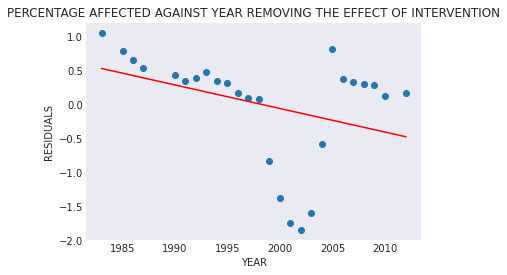

In [ ]:
# Plot residuals against year
plt.scatter(complete_avg_pct_affected_int_index_per_year_df.reset_index()["YEAR"], pct_from_intervention_residuals)
plot_regression_line(complete_avg_pct_affected_int_index_per_year_df.reset_index()["YEAR"], pct_from_intervention_residuals, log=True)
observed_r = correlation(complete_avg_pct_affected_int_index_per_year_df.reset_index()["YEAR"], pct_from_intervention_residuals, log=True)
plt.xlabel("YEAR")
plt.ylabel("RESIDUALS")
plt.title("PERCENTAGE AFFECTED AGAINST YEAR REMOVING THE EFFECT OF INTERVENTION")
fig(19)

We can see here that once the effect of the intervention has been removed, the negative correlation value for percentage affected and year weakens from $\sim-0.47$ from $\sim-0.35$.

When the theorised effect of intervention is removed, there is still a negative trend showing the percentage of coral affected decreasing over time. The decrease in percentage affected may be due to several reasons - as previously discussed at the beginning of our analysis, over the years there have been various types of interventions. One of which is the creation of MPAs which may have had long-lasting effects and therefore not be accounted for when considering later interventions. In addition to this, it is possible that the remaining coral has experienced a decrease in thermally susceptible genotypes as a form of natural selection. As a result of this, the coral may have adapted to have a higher thermal threshold for bleaching and therefore the percentage affected would decrease as observed (Sully, 2019). 

By conducting a permutation, we can compare a randomised percentage affected to our percentage affected data with the effect of intervention removed to evaluate the chance of the latter correlation occurring by chance.

In [ ]:
REPETITIONS = 10000
observed_df = complete_avg_pct_affected_int_index_per_year_non_mean_df.copy()
permutated_r = np.zeros(REPETITIONS)
for i in np.arange(REPETITIONS):
    #Shuffle % affected and intervention together (so we can remove effect of intervention)
    shuffled = np.random.permutation(list(zip(observed_df["INTERVENTION"], observed_df["PERCENTAGE_AFFECTED"])))
    #Replace existing data
    fake_df = observed_df.copy()
    fake_df["PERCENTAGE_AFFECTED"] = [i[1] for i in shuffled]
    fake_df["INTERVENTION"] = [i[0] for i in shuffled]
    fake_df = fake_df.groupby("YEAR").mean().reset_index()
    residuals = calc_residuals(fake_df, "INTERVENTION", "PERCENTAGE_AFFECTED")
    # Store correlation
    permutated_r[i] = correlation(fake_df["YEAR"], residuals)

permutated_pct = np.count_nonzero(permutated_r <= observed_r) / REPETITIONS
print(f"Percentage: {permutated_pct}\n\nObserved: {observed_r}\nClosest permutated: {np.min(permutated_r)}\nFurthest permutated: {np.max(permutated_r)}")

Percentage: 0.0383

Observed: -0.3523822017284026
Closest permutated: -0.6714032125992849
Furthest permutated: 0.6513744290037754


As the permutation test consistently provides a result of $.05$ and below, this tells us that when the intervention index is accounted for there is $\leq5\%$ chance that the results will randomly occur with as great a correlation as they did. 

## Conclusion
This analysis covered three main elements when exploring the severity of coral bleaching; time, distance from the equator, and the effect of intervention. We predicted that, in accordance with the literature, coral bleaching will:

* Worsen over time
* Be more severe closer to the equator
* Become less severe after intervention

**Severity over Time**

Contrary to hypothesised, our analysis found that there was a general downward trend in severity scores over time which could potentially be justified by data being recorded and therefore being monitored and this could be an indicator of intervention. Therefore, the intervention caused lower severity scores which were reflected in the data that was recorded.

**Summary of Location**

We expected to see less bleaching in the Middle East due to the higher resistance of corals and we expected to see more frequent bleaching events in Australia - particularly in the GBR. We also expected to see higher bleaching severity closer to the equator due to higher temperatures. The latter was reflected in our findings, however Australia showed lower severity than anticipated. After further exploration, we determined that this could be due to increased monitoring of the area regardless of bleaching due to the issues at the GBR, as there was also a large volume of data from Australia. With respect to our hypothesis concerning the Middle East, we did find less bleaching and while the dataset does not allow for further exploration, we theorise this is due to resistance as anticipated.

**Effect of Intervention**

When we removed the effect of intervention from our regression (percentage of coral affected over time), we found that a downwards trend was still present however was somewhat weakened showing that intervention did affect bleaching. Although we can speculate this trend may somewhat be explained by the longer-lasting effects of intervention, the dataset cannot provide any qualitative information on what could be causing this and therefore the question is outside the scope of this analysis.

## References  

Berkelmans, R., De’ath, G., Kininmonth, S., & Skirving, W. J. (2004). A comparison of the 1998 and 2002 coral bleaching events on the Great Barrier Reef: spatial correlation, patterns, and predictions. Coral Reefs, 23(1), 74–83. https://doi.org/10.1007/s00338-003-0353-y

eAtlas. (2015). GBR - Coral mass bleaching extent in 1998 and 2002 by aerial surveys (MTSRF 1.1.5, AIMS). Eatlas.org.au. https://eatlas.org.au/data/uuid/2a17791d-8175-481b-8d31-c25f02e66ef6

El Nino Southern Oscillation | Reef Resilience. (2016). El Nino Southern Oscillation | Reef Resilience. Reef Resilience Network. https://reefresilience.org/stressors/climate-and-ocean-change/el-nino-southern-oscillation/

Gowey, J. (2010). World Coral Bleaching Occurrences | Data Basin. Databasin.org. https://databasin.org/datasets/f57b0513-78a8-4f57-83fb-4a172f9c4c7b/#:~:text=Description%3A

Great Barrier Reef Foundation. (2021). Coral Bleaching. Great Barrier Reef Foundation. https://www.barrierreef.org/the-reef/threats/coral-bleaching

Great Barrier Reef Marine Park Authority. (2020). Coral bleaching 101. Www.gbrmpa.gov.au. https://www.gbrmpa.gov.au/the-reef/reef-health/coral-bleaching-101#:~:text=Out%20of%201036%20reefs%20surveyed 

NOAA. (2020). What Is Coral bleaching? Noaa.gov; Noaa. https://oceanservice.noaa.gov/facts/coral_bleach.html

Pallardy, R. (2019). Deepwater Horizon oil spill. In Encyclopædia Britannica. https://www.britannica.com/event/Deepwater-Horizon-oil-spill

ReefBase. (2016). “Coral Bleaching Data.” Harvard Dataverse, V1. https://doi.org/10.7910/DVN/KUVQKY

Ritchie, H., & Roser, M. (2021). Coral Reefs. Our World in Data. https://ourworldindata.org/coral-reefs

Shuail, D., Wiedenmann, J., D’Angelo, C., Baird, A. H., Pratchett, M. S., Riegl, B., Burt, J. A., Petrov, P., & Amos, C. (2016). Local bleaching thresholds established by remote sensing techniques vary among reefs with deviating bleaching patterns during the 2012 event in the Arabian/Persian Gulf. Marine Pollution Bulletin, 105(2), 654–659. https://doi.org/10.1016/j.marpolbul.2016.03.001


Sully, S., Burkepile, D. E., Donovan, M. K., Hodgson, G., & van Woesik, R. (2019). A global analysis of coral bleaching over the past two decades. Nature Communications, 10(1). https://doi.org/10.1038/s41467-019-09238-2  

UNESCO World Heritage Centre. (2009). Great Barrier Reef. Unesco.org; UNESCO. https://whc.unesco.org/en/list/154/


In [ ]:
## If you wish to create a pdf/html version of the analysis, set "DO_NOT_PROMPT" to "False"
## And rerun the cell then respond "Y".

DO_NOT_PROMPT = True

!python3 scripts/count_words.py analysis.ipynb
print("\n\n")
if not DO_NOT_PROMPT:
    if input("Generate PDF? (Y/n)").lower() != "n":
        !python3 scripts/generate_pdf.py analysis.ipynb exported_notebook/analysis


Total words: 7095
Code: 1909
Markdown: 5186





<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=15deb56a-811b-4642-b03e-885708f88a3a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>